<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# Exploration et Nettoyage des données



## Librairies

In [1]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import warnings

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

import sklearn.cross_validation as scv

/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Si vous utilisez la librairie `nltk` pour la première fois, il est nécessaire d'utiliser la commande suivante. Cette commande permet de télécharger de nombreux corpus de texte, mais également des informations grammaticales sur différentes langues. Information notamment nécessaire à l'étape de racinisation.

In [2]:
# nltk.download()

## Importation des données

* `cdiscount_train`: 1.000.000 de lignes
* `cdisount_test`: 50.000 lignes

   ### Read & Split Dataset
   On définit une fonction permettant de lire le fichier d'apprentissage et de créer deux DataFrame Pandas, un pour l'apprentissage, l'autre pour la validation.
   
   La fonction créée un DataFrame en lisant entièrement le fichier. Puis elle scinde ce DataFrame en deux grâce à la fonction dédiée de sklearn. 

In [3]:
def split_dataset(input_path, nb_line, tauxValid):
    data_all = pd.read_csv(input_path,sep=",")
    data_all = data_all.fillna("")
    data_train, data_valid = scv.train_test_split(data_all, test_size = tauxValid)
    time_end = time.time()
    return data_train, data_valid

In [4]:
input_path = "data/cdiscount_train.csv.zip"
nb_line=10000000  # part totale extraite du fichier initial ici déjà réduit
tauxValid = 0.05
data_train, data_valid = split_dataset(input_path, nb_line, tauxValid)
# Cette ligne permet de visualiser les 5 premières lignes de la DataFrame 
N_train = data_train.shape[0]
N_valid = data_valid.shape[0]
print("Train set : %d elements, Test set : %d elements" %(N_train, N_valid))
data_train.head(5)

Train set : 950000 elements, Test set : 50000 elements


,Categorie1,Categorie2,Categorie3,Description,Libelle,Marque
124821,LIBRAIRIE,AUTRES LIVRES,AUTRES LIVRES,De Michel Cremadez aux éditions ELSEVIER-MASSON,Le management strategique hospitalier,
380528,LIBRAIRIE,AUTRES LIVRES,AUTRES LIVRES,De Hornung Clarence aux éditions DOVER,Traditional japanese crest designs,
521644,DECO - LINGE - LUMINAIRE,DECORATION MURALE - TABLEAU - CADRE PHOTO - ST...,STICKERS - LETTRES ADHESIVES,Sticker lynx - Sticker lynx - couleur : Bleu M...,Sticker lynx,MPA DECO
449048,BIJOUX - LUNETTES - MONTRES,BIJOUX,BRACELET - GOURMETTE,Bracelet Jonc résine os de mouton jaune marbré...,Bijoux Bracelet Jonc résine os de mouton jaune,AUCUNE
393644,LOISIRS CREATIFS - BEAUX ARTS - PAPETERIE,ECRITURE - CALLIGRAPHIE,STYLO - PARURE DE STYLO - RECHARGE,PILOT Stylo roller retractable et rechargeable...,PILOT Stylo roller retractable et rechargeable …,PILOT


### Distribution des classes

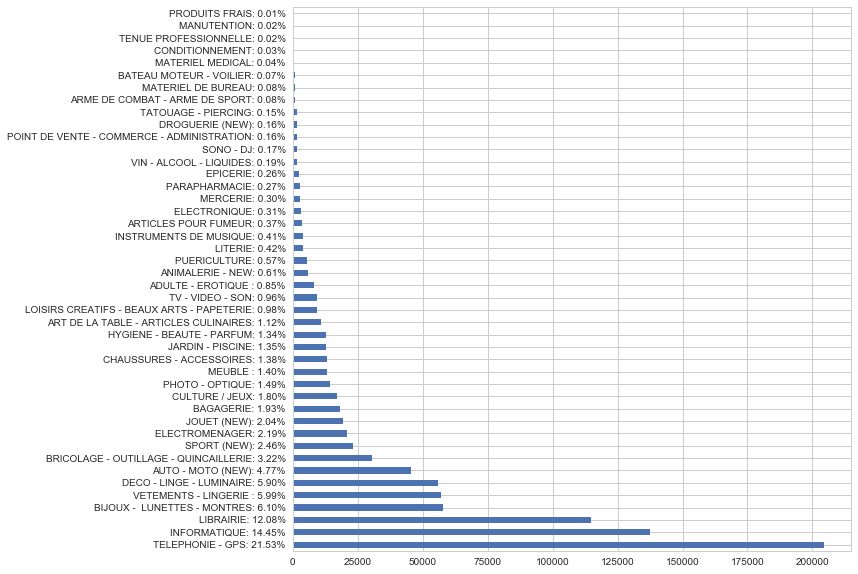

In [5]:
#Count occurence of each Categorie
data_count = data_train["Categorie1"].value_counts()
#Rename index to add percentage
new_index = [k+ ": %.2f%%" %(v*100/N_train) for k,v in data_count.iteritems()]
data_count.index= new_index

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
data_count.plot.barh(logx = False)
plt.show()

Que peut-on dire sur la distribution des ce classes?

### Sauvegarde des données

On sauvegarde dans des csv les fichiers `train` et `validation` afin que ces mêmes fichiers soit ré-utilisés plus tard dans d'autre calepin

In [6]:
data_valid.to_csv("data/cdiscount_valid.csv", index=False)
data_train.to_csv("data/cdiscount_train_subset.csv", index=False)

##  Nettoyage des données
Afin de limiter la dimension de l'espace des variables ou *features*, tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:
* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### Importation des librairies et fichier pour le nettoyage des données.

In [7]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # Nettoyage des données

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords =open("data/lucene_stopwords.txt","r").read().split(",") #En local
## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')

### Exemple 

**Ligne Originale**

In [8]:
i = 34543
description = data_train.Description.values[i]
print("Original Description : " + description)

Original Description : Porte-Clé Dingo - Des porte-clé Disney au style pop unique signé Roméro Britto. Pratique avec ses 2 attaches, un anneau de porte-clé et un mousqueton pour customiser rapidemen… Voir la présentation


** Supprime les posibles balises HTML dans la description **

In [9]:
txt = BeautifulSoup(description,"html.parser",from_encoding='utf-8').get_text()
print(txt)

Porte-Clé Dingo - Des porte-clé Disney au style pop unique signé Roméro Britto. Pratique avec ses 2 attaches, un anneau de porte-clé et un mousqueton pour customiser rapidemen… Voir la présentation


/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


** Convertit le texte en minuscule **

In [10]:
txt = txt.lower()
print(txt)

porte-clé dingo - des porte-clé disney au style pop unique signé roméro britto. pratique avec ses 2 attaches, un anneau de porte-clé et un mousqueton pour customiser rapidemen… voir la présentation


** Remplace quelques caractères spéciaux **

* `\u2026`: `…`
* `\u00a0`: `NO-BREAK SPACE`

Cette liste peut être etayer en fonction du jeu de donées étudiés

In [11]:
txt = txt.replace(u'\u2026','.')    
txt = txt.replace(u'\u00a0',' ')
print(txt)

porte-clé dingo - des porte-clé disney au style pop unique signé roméro britto. pratique avec ses 2 attaches, un anneau de porte-clé et un mousqueton pour customiser rapidemen. voir la présentation


** Supprime les accents **

In [12]:
txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
print(txt)

porte-cle dingo - des porte-cle disney au style pop unique signe romero britto. pratique avec ses 2 attaches, un anneau de porte-cle et un mousqueton pour customiser rapidemen. voir la presentation


** Supprime les caractères qui ne sont ne sont pas des lettres minuscules **

In [13]:
txt = re.sub('[^a-z_]', ' ', txt)
print(txt)

porte cle dingo   des porte cle disney au style pop unique signe romero britto  pratique avec ses   attaches  un anneau de porte cle et un mousqueton pour customiser rapidemen  voir la presentation


** Remplace la description par une liste de mots (tokens), supprime les mots de moins de 2 lettres ainsi que les stopwords **


In [14]:
tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
print(tokens)

['porte', 'cle', 'dingo', 'porte', 'cle', 'disney', 'style', 'pop', 'unique', 'signe', 'romero', 'britto', 'pratique', 'attaches', 'anneau', 'porte', 'cle', 'mousqueton', 'customiser', 'rapidemen', 'voir', 'presentation']


** Racinise (Stem) chaque tokens **

In [15]:
tokens_stem = [stemmer.stem(token) for token in tokens]
print(tokens_stem)

['port', 'cle', 'dingo', 'port', 'cle', 'disney', 'styl', 'pop', 'uniqu', 'sign', 'romero', 'britto', 'pratiqu', 'attach', 'anneau', 'port', 'cle', 'mousqueton', 'customis', 'rapidemen', 'voir', 'present']


In [16]:
data_train.values[12354]

array(['INFORMATIQUE', 'PROTECTION - PERSONNALISATION - SUPPORT',
       'COQUE - HOUSSE',
       'Cover . iPad 4/3/2 blanc et gris - Les points clés . Type de produit : Housse et protection. Compatibilité : iPad. Les p de ce modele . Avantages : Ré',
       'Cover . iPad 4-3-2 blanc et gris', 'LIFEPROOF'], dtype=object)

### Fonction de nettoyage de texte
Fonction qui prend en entrée un texte et retourne le texte nettoyé en appliquant successivement les étapes présentés précedemment. 

In [17]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text()
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens_stem = [stemmer.stem(token) for token in tokens]
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens), " ".join(tokens_stem)

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

Applique le nettoyage sur toutes les lignes de la DataFrame et créé deux nouvelles Dataframe (avant et sans l'étape de racinisation).

In [18]:
from multiprocessing import Pool
p = Pool(4)
    
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Description', 'Libelle', 'Marque']):

    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    clean_stem_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Marque":
            array_clean = np.array(list(p.map(clean_marque,column)))
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean)
        else:
            A = np.array(list(p.map(clean_txt,column)))
            array_clean = A[:,0]
            array_clean_stem = A[:,1]
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean_stem)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    
    array_clean_stem = np.array(clean_stem_list).T
    data_clean_stem = pd.DataFrame(array_clean_stem, columns = column_names)
    return data_clean, data_clean_stem

/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will 

### Nettoyage des DataFrames

In [19]:
# Take approximately 2 minutes fors 100.000 rows
data_valid_clean, data_valid_clean_stem = clean_df(data_valid)

Start Clean 50000 lines
Cleaning time: 12 secondes


In [20]:
data_train_clean, data_train_clean_stem = clean_df(data_train)

Start Clean 950000 lines
Cleaning time: 240 secondes


Affiche les 5 premières lignes de la DataFrame d'apprentissage après nettoyage.

In [21]:
data_train_clean.head(5)

,Description,Libelle,Marque
0,michel cremadez editions elsevier masson,management strategique hospitalier,
1,hornung clarence editions dover,traditional japanese crest designs,
2,sticker lynx sticker lynx couleur bleu moyen t...,sticker lynx,mpa_deco
3,bracelet jonc resine mouton jaune marbre diame...,bijoux bracelet jonc resine mouton jaune,aucune
4,pilot stylo roller retractable rechargeable po...,pilot stylo roller retractable rechargeable,pilot


In [22]:
data_train_clean_stem.head(5)

,Description,Libelle,Marque
0,michel cremad edit elsevi masson,manag strateg hospitali,
1,hornung clarenc edit dov,traditional japanes crest design,
2,stick lynx stick lynx couleur bleu moyen taill...,stick lynx,mpa_deco
3,bracelet jonc resin mouton jaun marbr diametr ...,bijoux bracelet jonc resin mouton jaun,aucune
4,pilot stylo roll retract recharge point tec bl...,pilot stylo roll retract recharge,pilot


Taille du dictionnaire de mots pour le dataset avant et après la racinisation.

In [23]:
concatenate_text = " ".join(data_train_clean["Description"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

260102


In [24]:
concatenate_text = " ".join(data_train_clean_stem["Description"].values)
list_of_word_stem = concatenate_text.split(" ")
N = len(set(list_of_word_stem))
print(N)

208620


### Wordcloud

In [31]:
from wordcloud import WordCloud

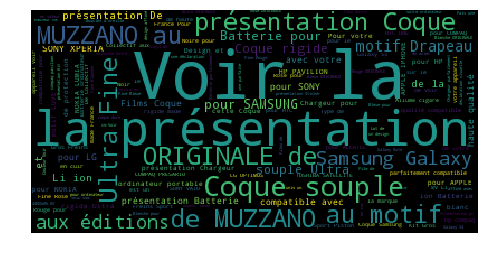

In [33]:
all_descr = " ".join(data_valid.Description.values)
wordcloud_word = WordCloud(background_color="black").generate_from_text(all_descr)

plt.figure()
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

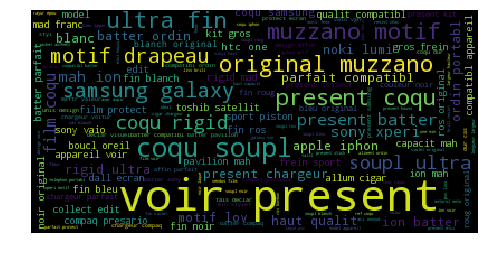

In [35]:
all_descr_clean_stem = " ".join(data_valid_clean_stem.Description.values)
wordcloud_word = WordCloud(background_color="black").generate_from_text(all_descr_clean_stem)

plt.figure()
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

## Sauvegarde des jeux de données nettoyés dans des fichiers csv.

In [26]:
data_valid_clean.to_csv("data/cdiscount_valid_clean.csv", index=False)
data_train_clean.to_csv("data/cdiscount_train_clean.csv", index=False)

data_valid_clean_stem.to_csv("data/cdiscount_valid_clean_stem.csv", index=False)
data_train_clean_stem.to_csv("data/cdiscount_train_clean_stem.csv", index=False)